In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import learning_curve


# Import data

In [8]:
gdpnow = pd.read_csv('gdpnow_hf.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)
# Ensure that load_df index is in the same date format
gdpnow.index = pd.to_datetime(gdpnow.index)

In [9]:
gdpnow

,GSUSFCI Index,CESIUSD Index,value_MORTGAGE30US,value_CCLACBW027SBOG,value_WTISPLC,value_EXPINF1YR,value_STLPPM,value_ECIWAG,value_M2REAL,value_UNRATE,...,PCE Goods,PCE Services,Previous change in private inventories ($Bil 2009),Publication Date of Advance Estimate,Quarter being forecasted,Residential,S&L,Services exports,Services imports,Structures
Dates,,,,,,,,,,,,,,,,,,,,,
2014-05-01,99.01,-28.7,4.29,608.7653,102.18,1.768390,0.227347,121.1,4778.4,6.3,...,5.8,3.9,70.0,30/07/2014,30/06/2014,4.6,1.4,2.5,4.0,1.8
2014-05-02,99.00,-18.9,4.29,608.7653,102.18,1.768390,0.227347,121.1,4778.4,6.3,...,5.8,3.9,58.0,30/07/2014,30/06/2014,4.6,1.3,2.5,4.0,1.8
2014-05-05,99.01,-12.6,4.29,608.7653,102.18,1.768390,0.227347,121.1,4778.4,6.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-06,99.02,-12.0,4.29,608.7653,102.18,1.768390,0.227347,121.1,4778.4,6.3,...,5.4,3.9,58.0,30/07/2014,30/06/2014,4.5,1.3,2.7,3.3,1.8
2014-05-07,99.00,-11.2,4.29,608.7653,102.18,1.768390,0.227347,121.1,4778.4,6.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-15,99.34,5.4,6.66,1033.2235,74.15,2.418633,0.940888,155.8,6710.6,3.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-16,99.47,-2.4,6.66,1033.2235,74.15,2.418633,0.940888,155.8,6710.6,3.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-17,99.51,1.4,6.66,1035.5004,74.15,2.418633,0.940888,155.8,6710.6,3.7,...,3.6,2.4,77.8,25/01/2024,31/12/2023,0.2,3.6,5.6,5.7,2.0


## Let's define X and y

In [4]:
Target = 'Final_GDP_Interp'
Drop = ['GDP Nowcast', 'Final_GDP_Interp', 'Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
       'Days until advance estimate', 'Forecast Error', 'Data releases']

# How to deal with all the NAs ?

From here on lets try two different datasets as in how to work with the NAs:
1. ffil
2. dropping NAs

In [5]:
len(gdpnow.columns)

NameError: name 'gdpnow' is not defined

In [6]:
gdpnow_filled = gdpnow.fillna(method='ffill')
# Two variables are empty quite a lot
gdpnow_dropped = gdpnow.dropna(axis=0, thresh=len(gdpnow.columns)-2)

NameError: name 'gdpnow' is not defined

In [7]:
gdpnow_filled.shape, gdpnow_dropped.shape

((2537, 63), (1496, 63))

# Defining X and y

We now need the X and Y for the three different data sets

In [8]:
# defining X and y for all three data sets (initial, dropped and filled)
X = gdpnow.drop(columns=Drop)
y = gdpnow[Target]

X_filled = gdpnow_filled.drop(columns=Drop)
y_filled = gdpnow_filled[Target]

X_dropped = gdpnow_dropped.drop(columns=Drop)
y_dropped = gdpnow_dropped[Target]

assert(X.shape[0]==y.shape[0])
assert(X_filled.shape[0]==y_filled.shape[0])
assert(X_dropped.shape[0]==y_dropped.shape[0])

In [9]:
# Splitting into test and train sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20)

X_filled_train, X_filled_test, y_filled_train, y_filled_test = \
    train_test_split(X_filled, y_filled, test_size=0.20)

X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = \
    train_test_split(X_dropped, y_dropped, test_size=0.20)


# Pipeline

In [10]:
preproc = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

preproc_selector = Pipeline([
    ('preprocessing', preproc),  # Include the preprocessing steps with PCA
    ('feature_selection', SelectPercentile(
        mutual_info_regression,
        percentile=90 # Keep 90% of all features
    ))
])

# Modeling

In [11]:
#Modeling with initial dataset

# model = XGBRegressor(random_state=42)

# param_distributions = {
#     'model__n_estimators': [200],
#     'model__learning_rate': [0.1],
#     'model__max_depth': [16, 20],
# }

# pipe = Pipeline([
#     ('preprocessor', preproc),
#     ('model', model)
# ])

# random_search = RandomizedSearchCV(
#     pipe,
#     param_distributions=param_distributions,
#     n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
#     scoring='r2',  # Assuming MSE is the metric of interest; adjust as needed.
#     cv=5,
#     verbose=2,
#     #random_state=42,
#     n_jobs=-1  # Use all available cores
# )

# random_search.fit(X_train, y_train)

# print("Best parameters found: ", random_search.best_params_)
# print("Best score found: ", random_search.best_score_)

In [12]:
# random_search.score(X_test, y_test)

In [13]:
# #Modeling with filled dataset

# model = XGBRegressor(random_state=42)

# param_distributions = {
#     'model__n_estimators': [200],
#     'model__learning_rate': [0.1],
#     'model__max_depth': [16, 20],
# }

# pipe = Pipeline([
#     ('preprocessor', preproc),
#     ('model', model)
# ])

# random_search_filled = RandomizedSearchCV(
#     pipe,
#     param_distributions=param_distributions,
#     n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
#     scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
#     cv=5,
#     verbose=0,
#     random_state=42,
#     n_jobs=-1  # Use all available cores
# )

# random_search_filled.fit(X_filled_train, y_filled_train)

# print("Best parameters found: ", random_search_filled.best_params_)
# print("Best score found: ", random_search_filled.best_score_)

In [14]:
# random_search_filled.score(X_filled_test, y_filled_test)

In [15]:
#Modeling with 'dropped' dataset

model = XGBRegressor(random_state=42)

param_distributions = {
    'model__n_estimators': [200],
    'model__learning_rate': [0.1],
    'model__max_depth': [16, 20],
}

pipe = Pipeline([
    ('preprocessor', preproc),
    ('model', model)
])

random_search_dropped = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
    scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search_dropped.fit(X_dropped_train, y_dropped_train)

print("Best parameters found: ", random_search_dropped.best_params_)
print("Best score found: ", random_search_dropped.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/die_gregette/.pyenv/versions/3.10.6/envs/project-btm/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=   2.8s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=   2.8s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=   2.9s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=   2.9s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=   2.9s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   3.1s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   3.1s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   3.1s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   1.7s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   1.7s


In [16]:
random_search_dropped.score(X_dropped_test, y_dropped_test)

-0.19741370504145783

In [17]:
y_dropped_pred = random_search_dropped.predict(X_dropped_test)

In [18]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate evaluation metrics
mae_train = mean_absolute_error(y_dropped_train, random_search_dropped.predict(X_dropped_train))
mae_test = mean_absolute_error(y_dropped_test, random_search_dropped.predict(X_dropped_test))
r2_train = r2_score(y_dropped_train, random_search_dropped.predict(X_dropped_train))
r2_test = r2_score(y_dropped_test, random_search_dropped.predict(X_dropped_test))

print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Train R^2:", r2_train)
print("Test R^2:", r2_test)

Train MAE: 0.0007422393136483038
Test MAE: 0.19741370504145783
Train R^2: 0.9999999713882043
Test R^2: 0.9815959064010407


# Finetuning

### Using a feature selector

We have shown that either filling in or dropping gives way more promising results than just imputing

Thus, we will focus on these approaches

In [19]:
#Modeling with filled dataset

# model = XGBRegressor(random_state=42)

# param_distributions = {
#     'model__n_estimators': [200],
#     'model__learning_rate': stats.uniform(0.01 , 0.5),
#     'model__max_depth': [16, 20],
#      'preprocessor_selector__feature_selection__percentile': [60, 70, 80, 90],
# }

# pipe = Pipeline([
#     ('preprocessor_selector', preproc_selector),
#     ('model', model)
# ])

# random_search_filled = RandomizedSearchCV(
#     pipe,
#     param_distributions=param_distributions,
#     n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
#     scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
#     cv=5,
#     verbose=0,
#     random_state=42,
#     n_jobs=-1  # Use all available cores
# )

# random_search_filled.fit(X_filled_train, y_filled_train)

# print("Best parameters found: ", random_search_filled.best_params_)
# print("Best score found: ", random_search_filled.best_score_)

In [40]:
#Modeling with dropped dataset

model = XGBRegressor(random_state=42)

param_distributions = {
    'model__n_estimators': stats.randint(100,300),
    'model__learning_rate': stats.uniform(0.01 , 0.5),
    'model__max_depth': stats.randint(6,20),
    'preprocessor_selector__feature_selection__percentile': stats.uniform(10,90),
}

pipe = Pipeline([
    ('preprocessor_selector', preproc_selector),
    ('model', model)
])

random_search_dropped = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=1000,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
    scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search_dropped.fit(X_dropped_train, y_dropped_train)

print("Best parameters found: ", random_search_dropped.best_params_)
print("Best score found: ", random_search_dropped.best_score_)

/Users/die_gregette/.pyenv/versions/3.10.6/envs/project-btm/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'model__learning_rate': 0.2793508989763571, 'model__max_depth': 9, 'model__n_estimators': 105, 'preprocessor_selector__feature_selection__percentile': 43.47394011251784}
Best score found:  -0.19153434957374046


In [41]:
random_search_dropped.score(X_dropped_test, y_dropped_test)
# {'model__learning_rate': 0.2793508989763571, 'model__max_depth': 9, 'model__n_estimators': 105, 'preprocessor_selector__feature_selection__percentile': 43.47394011251784}

-0.18776662957460688

In [ ]:
# {'model__learning_rate': 0.27629471627579294, 'model__max_depth': 12, 'model__n_estimators': 200, 'preprocessor_selector__feature_selection__percentile': 43.23074333589065}

In [22]:
y_pred = random_search_dropped.predict(X_dropped_test)

In [23]:
y_pred = pd.Series(y_pred).reset_index(drop = True)

In [24]:
y_pred.index = y_dropped_test.index
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_plot = pd.concat([gdpnow.loc[X_dropped_test.index]['Days until advance estimate'], y_dropped_test, y_pred], axis=1)
df_plot

,Days until advance estimate,Final_GDP_Interp,0
Dates,,,
2019-07-12,14.0,2.230769,2.227014
2015-02-23,65.0,1.995506,1.950356
2023-09-19,37.0,3.875714,3.742326
2020-02-26,63.0,0.022000,0.491107
2015-10-02,27.0,1.736264,1.708955
...,...,...,...
2018-05-11,77.0,2.587692,2.701230
2023-10-27,90.0,4.861412,4.749522
2019-12-23,38.0,2.013913,2.008334


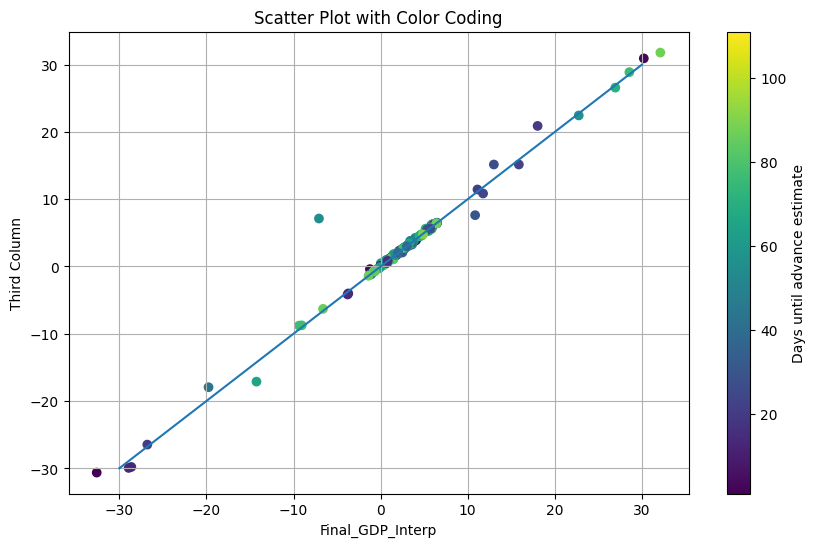

In [25]:
a=[-30,30]
b=[-30,30]

plt.figure(figsize=(10, 6))
plt.plot(a,b)
scatter = plt.scatter(df_plot['Final_GDP_Interp'], df_plot[0], c=df_plot['Days until advance estimate'], cmap='viridis')
plt.colorbar(scatter, label='Days until advance estimate')
plt.xlabel('Final_GDP_Interp')
plt.ylabel('Third Column')
plt.title('Scatter Plot with Color Coding')
plt.grid(True)
plt.show()

# Comparing scores with GDPNOW

In [26]:
gdpnow_test = gdpnow_dropped['GDP Nowcast']
gdpnow_test = gdpnow_test.interpolate(method='time')
gdp_test = gdpnow_dropped['Final_GDP_Interp']

In [27]:
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:

    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    if type(y_pred) == pd.Series:
        mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
        maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    else:
        mins = np.amin(np.hstack([y_pred.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
        maxs = np.amax(np.hstack([y_pred.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'acf1':acf1,
        'corr':corr,
        'minmax':minmax
    })

    return forecast

In [28]:
forecast_accuracy(random_search_dropped.predict(X_dropped_test), y_dropped_test)

{'mape': 0.13620878035938613,
 'me': 0.059304090924589326,
 'mae': 0.1892530569865535,
 'mpe': 0.05550339531507021,
 'rmse': 0.9132816288543603,
 'acf1': -0.02354532829797496,
 'corr': 0.9877232142049297,
 'minmax': 0.026041872506264996}

In [29]:
forecast_accuracy(gdpnow_test,gdp_test)

/var/folders/m3/r24zxwy93v34dzftq6dr3sjw0000gn/T/ipykernel_8226/1438552970.py:15: RuntimeWarning: divide by zero encountered in divide
  minmax = 1 - np.mean(mins/maxs)             # minmax


{'mape': 1.0052173257056338,
 'me': 0.4431112847125225,
 'mae': 2.7196656763835896,
 'mpe': 0.22596797133268812,
 'rmse': 7.243805910567935,
 'acf1': 0.9706041856039092,
 'corr': 0.5693452275251626,
 'minmax': inf}

# Learning curves

In [36]:
# preproc_selector
X_scaled = preproc_selector.fit_transform(X_dropped, y_dropped)

((1496, 49), (1496, 55))

/Users/die_gregette/.pyenv/versions/3.10.6/envs/project-btm/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/die_gregette/.pyenv/versions/3.10.6/envs/project-btm/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/die_gregette/.pyenv/versions/3.10.6/envs/project-btm/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/die_gregette/.pyenv/versions/3.10.6/envs/project-btm/lib/python3.10/site-packages/joblib/externals/lok

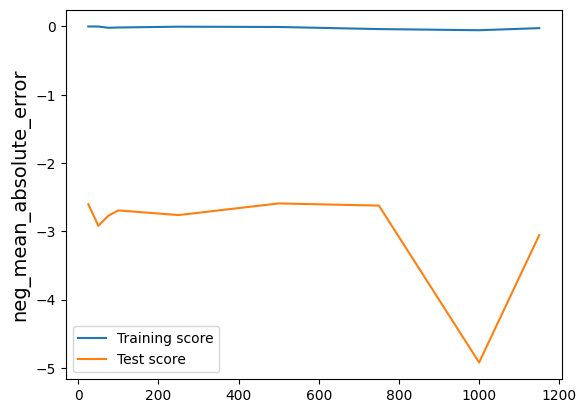

In [37]:
train_sizes = [25,50,75,100,250,500,750,1000,1150]

# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=random_search_dropped, X=X_dropped, y=y_dropped,
    train_sizes=train_sizes, cv=5, scoring='neg_mean_absolute_error')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('neg_mean_absolute_error', fontsize = 14)
plt.legend(loc="best")
